In [1]:
from glob import glob
import sys
import getpass
import os
from os.path import join, dirname, getsize
import pickle
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

import nilearn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef as my Class correction for projects
import mydef

/home/sungbeenpark/anaconda3/envs/sampark/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
GA = mydef.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


## 1. ROI list

In [3]:
## initalizing
GA.roi_imgs = {}

- Localizer

In [4]:
suffix = 'all_localizers'

- Yeo networks

In [3]:
suffix = 'Yeo_network17_1'

## 2. Loading result

In [4]:
GA.show_pkl_list(path=GA.dir_script, word='decacc.%s'%suffix)

,name,identity
0,./20210813_decacc.Yeo_network17_1.pkl,a


In [5]:
GA.make_df_score(fname='./20210813_decacc.%s.pkl'%suffix)

,subj,stage,ROI,mean_accuracy
0,01,early_practice,FuG_L_3_2,0.493056
1,01,early_practice,FuG_R_3_2,0.489583
2,01,early_practice,MVOcC_L_5_1,0.614583
3,01,early_practice,MVOcC_R_5_1,0.604167
4,01,early_practice,MVOcC_L_5_3,0.770833
...,...,...,...,...
1795,44,late_unpractice,LOcC_R_4_3,0.590278
1796,44,late_unpractice,LOcC_L_4_4,0.506944
1797,44,late_unpractice,LOcC_R_4_4,0.579861
1798,44,late_unpractice,LOcC_L_2_2,0.444444


In [6]:
roi = 'yeo_network17_1'
GA.df_score = GA.df_score[GA.df_score.ROI==roi]
GA.df_score

,subj,stage,ROI,mean_accuracy
14,01,early_practice,yeo_network17_1,0.819444
29,01,early_unpractice,yeo_network17_1,0.649306
44,01,late_practice,yeo_network17_1,0.559028
59,01,late_unpractice,yeo_network17_1,0.791667
74,02,early_practice,yeo_network17_1,0.746528
...,...,...,...,...
1739,42,late_unpractice,yeo_network17_1,0.284722
1754,44,early_practice,yeo_network17_1,0.604167
1769,44,early_unpractice,yeo_network17_1,0.850694
1784,44,late_practice,yeo_network17_1,0.927083


In [7]:
stage = []
mapping = []
for string in list(GA.df_score.stage):
    [s,m] = string.split('_')
    stage.append(s)
    mapping.append(m)

In [8]:
temp = pd.DataFrame()

temp['subj'] = GA.df_score.subj
temp['stage'] = stage # 독립변수 1
temp['mapping'] = mapping # 독립변수 2
temp['ROI'] = GA.df_score.ROI
temp['mean_accuracy'] = GA.df_score.mean_accuracy # 종속변수
temp

,subj,stage,mapping,ROI,mean_accuracy
14,01,early,practice,yeo_network17_1,0.819444
29,01,early,unpractice,yeo_network17_1,0.649306
44,01,late,practice,yeo_network17_1,0.559028
59,01,late,unpractice,yeo_network17_1,0.791667
74,02,early,practice,yeo_network17_1,0.746528
...,...,...,...,...,...
1739,42,late,unpractice,yeo_network17_1,0.284722
1754,44,early,practice,yeo_network17_1,0.604167
1769,44,early,unpractice,yeo_network17_1,0.850694
1784,44,late,practice,yeo_network17_1,0.927083


## 3. Two-way repeated measurement ANOVA (pingouin)

In [9]:
from pingouin import rm_anova

In [16]:
print(roi)
rm_anova(data=temp
         , dv= 'mean_accuracy'
         , subject='subj'
         , within=['stage','mapping']
         , effsize='np2')

yeo_network17_1


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,stage,0.066898,1,29,0.066898,2.825890,0.103497,0.103497,0.088792,1.0
1,mapping,0.010809,1,29,0.010809,2.935316,0.097334,0.097334,0.091914,1.0
2,stage * mapping,0.026337,1,29,0.026337,3.276269,0.080663,0.080663,0.101507,1.0


## ?. Loading ANOVA data

In [7]:
gg = 'GA'
anova = nilearn.image.load_img(join(GA.dir_stats,'ANOVA','ANOVA.%s.MO.shortdur.4target+tlrc.nii.gz'%gg))

In [7]:
print(anova.shape)
# nilearn.plotting.plot_glass_brain(anova)

(72, 85, 72, 1, 42)


In [8]:
type(anova)

nibabel.nifti1.Nifti1Image

In [15]:
anova.header

1. M1

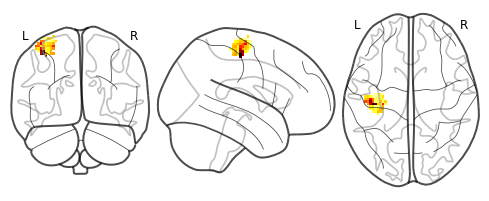

In [12]:
masked_anova = nilearn.image.math_img(
    img1=anova, img2=GA.roi_imgs['n200_c1-1_L_M1']
    , formula='img1 * img2'
)
nilearn.plotting.plot_glass_brain(masked_anova)

2. S1

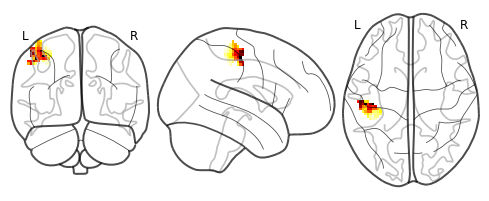

In [13]:
masked_anova = nilearn.image.math_img(
    img1=anova, img2=GA.roi_imgs['n200_c1-2_L_S1']
    , formula='img1 * img2'
)
nilearn.plotting.plot_glass_brain(masked_anova)